# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Análise Estatística Para Data Science com Linguagem Python</font>

## <font color='blue'>Lab 6</font>
### <font color='blue'>Forecasting - Previsões de Séries Temporais - Prevendo a Demanda de Produtos ao Longo do Tempo</font>

![title](imagens/Lab6.png)

## Instalando e Carregando os Pacotes

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.18


In [ ]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
# !pip install -q -U watermark

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

numpy      : 1.26.4
matplotlib : 3.8.2
statsmodels: 0.14.1
pandas     : 2.0.3



## Definição do Problema

Uma empresa deseja prever a demanda por produtos durante o ano de 2024, para cada um dos 12 meses. O objetivo é planejar produção e logística ajustando o orçamento.

A empresa possui dados históricos com a demanda mensal de produtos entre 2012 e 2023. Crie um modelo e entregue o forecasting para os 12 meses de 2024. Use um modelo ARIMA para que o modelo seja facilmente interpretável.

In [4]:
# Carregando os dados
df = pd.read_csv("dados/dataset.csv", parse_dates= ['Mes'], index_col = ['Mes'])

In [5]:
df.shape

(144, 1)

In [6]:
df.head()

,Demanda_Produtos
Mes,
2012-01-01,114
2012-02-01,119
2012-03-01,133
2012-04-01,127
2012-05-01,123


In [7]:
df.tail()

,Demanda_Produtos
Mes,
2023-08-01,606
2023-09-01,508
2023-10-01,461
2023-11-01,390
2023-12-01,432


<Axes: xlabel='Mes'>

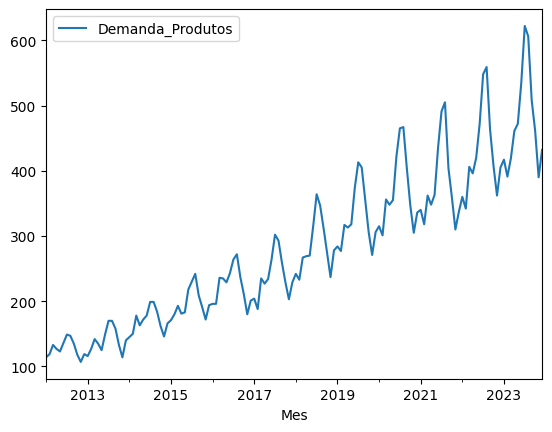

In [8]:
df.plot()

## Testando a Estacionaridade da Série Temporal com Teste Estatístico Dickey-Fuller

In [9]:
# Testando a estacionaridade dos dados
resultado = adfuller(df['Demanda_Produtos'])
print('Estatística ADF: %f' % resultado[0])
print('Valor-p: %f' % resultado[1])

Estatística ADF: 0.832549
Valor-p: 0.992144


Aqui estamos usando o teste Augmented Dickey-Fuller (ADF) para verificar a estacionaridade da série temporal em questão. A estacionaridade é uma propriedade importante das séries temporais, onde as propriedades estatísticas, como média, variância e covariância, são constantes ao longo do tempo.

Aqui está a interpretação dos resultados:

**Estatística ADF**: É o valor da estatística do teste. Neste caso, o valor é positivo (0.832549), o que é uma forte indicação de que a série não é estacionária.

**Valor-p**: Este valor te dá a probabilidade de obter o resultado do teste (ou algo mais extremo), assumindo que a hipótese nula seja verdadeira. A hipótese nula do teste ADF é que a série temporal tem uma raiz unitária, o que significa que ela não é estacionária.

Se o Valor-p fosse abaixo de um nível de significância comum, como 0,05, você rejeitaria a hipótese nula e concluiria que a série temporal é estacionária.

Neste caso, o Valor-p é 0.992144, o que é muito maior do que 0,05. Assim, você falha em rejeitar a hipótese nula e deve concluir que a série temporal tem uma raiz unitária, indicando que ela não é estacionária.

A falta de estacionaridade em sua série pode causar problemas ao tentar modelá-la com métodos de séries temporais que assumem essa propriedade. Você pode considerar diferenciar a série (isto é, calcular a diferença entre observações consecutivas) para tentar torná-la estacionária antes de prosseguir com a análise. É o que faremos abaixo.

In [10]:
# Diferenciando os dados para torná-los estacionários
df_diff = df.diff().dropna()

In [11]:
# Testando a estacionaridade dos dados
resultado = adfuller(df_diff['Demanda_Produtos'])
print('ADF Statistic: %f' % resultado[0])
print('Valor-p: %f' % resultado[1])

ADF Statistic: -2.846252
Valor-p: 0.051965


Uma diferenciação não foi suficiente para tornar a série estacionária. Vamos aplicar a segunda diferenciação.

In [12]:
# Diferenciando os dados para torná-los estacionários
df_diff2 = df_diff.diff().dropna()

In [13]:
# Testando a estacionaridade dos dados
resultado = adfuller(df_diff2['Demanda_Produtos'])
print('ADF Statistic: %f', resultado[0])
print('Valor-p: %f' % resultado[1])

ADF Statistic: %f -16.365337803764533
Valor-p: 0.000000


Agora sim a série é estacionária, após duas diferenciações. 

Os parâmetros (p, d, q) do modelo ARIMA correspondem aos componentes AutoRegressive (AR), Integrated (I) e Moving Average (MA), respectivamente. Para o modelo ARIMA ser efetivo, é necessário escolher os valores corretos para esses parâmetros.

Usaremos d = 2 no modelo ARIMA seguir. Precisamos agora definir os parâmetros p e q.

## Forecasting com Modelo ARIMA

ARIMA, que significa Modelo Autoregressivo Integrado de Médias Móveis, é um modelo de previsão de séries temporais. Este modelo descreve uma forma específica de dependência temporal, muito adequada para dados de séries temporais econômicas e financeiras.

O modelo ARIMA tem três componentes principais:

AR (Autoregressive) - Este componente se refere ao uso de observações de períodos de tempo anteriores para prever o valor no próximo período. Isso é semelhante à regressão linear, mas é usado com dados de séries temporais.

I (Integrated) - Este componente é usado para tornar a série temporal estacionária, o que é feito pela diferença entre as observações em diferentes períodos de tempo.

MA (Moving Average) - Este componente é usado para modelar o erro de previsão como uma combinação linear dos termos de erro do passado.

Os parâmetros p, d e q são números inteiros não negativos que se referem à ordem dos componentes AR, I e MA, respectivamente.

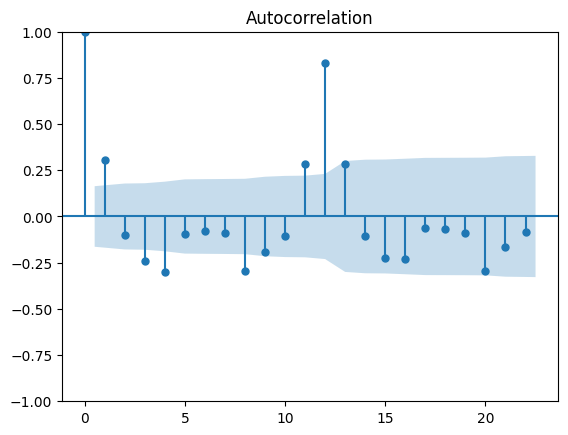

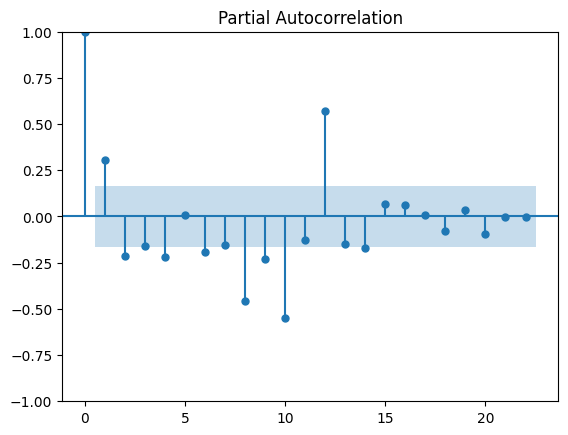

In [14]:
# Verificando os gráficos ACF e PACF para determinar os valores de p e q
plot_acf(df_diff)
plot_pacf(df_diff)
plt.show()

Os parâmetros (p, d, q) no modelo ARIMA correspondem aos componentes AutoRegressive (AR), Integrated (I) e Moving Average (MA), respectivamente. Para o modelo ARIMA ser efetivo, é necessário escolher os valores corretos para esses parâmetros.

A regra geral é a seguinte:

p: A ordem do componente autoregressivo (AR). Esse número representa a quantidade de lags da série temporal que serão incluídos como preditores. Para determinar o valor adequado de p, você pode examinar a função de autocorrelação parcial (PACF) e procurar o ponto em que a autocorrelação se torna insignificante.

d: A ordem da diferenciação necessária para tornar a série temporal estacionária. Se a série original já é estacionária, d = 0. Se não, você pode começar diferenciando a série uma vez e testar a estacionaridade (como através do teste ADF, por exemplo). Se ainda não for estacionária, você pode diferenciá-la novamente e repetir o teste, incrementando d até que a série se torne estacionária.

q: A ordem do componente da média móvel (MA). Esse número indica a quantidade de lags das previsões de erro que devem ser usadas como preditores. A função de autocorrelação (ACF) pode ser usada para identificar o valor adequado de q. Semelhante à PACF, você procuraria o ponto em que a autocorrelação se torna insignificante.

Como as séries temporais podem ser complexas e os métodos gráficos nem sempre são definitivos, a seleção de p, d e q geralmente envolve um pouco de tentativa e erro. Você pode ajustar vários modelos ARIMA com diferentes combinações de p, d e q, e usar critérios como o Critério de Informação de Akaike (AIC) ou o Critério de Informação Bayesiano (BIC) para compará-los. Esses critérios penalizam a complexidade do modelo (ou seja, modelos com mais parâmetros) e recompensam o ajuste do modelo, ajudando a encontrar o equilíbrio certo entre complexidade e ajuste.

In [15]:
# Construindo o modelo ARIMA (p,d,q)
modelo = ARIMA(df, order = (3,2,2))

In [16]:
# Treinando o modelo
modelo_fit = modelo.fit()

In [17]:
# Imrimindo o AIC
print(modelo_fit.aic)

1392.670465852219


O Critério de Informação de Akaike (AIC) é uma medida usada para comparar modelos estatísticos. Ele leva em consideração tanto a qualidade do ajuste quanto a complexidade do modelo, penalizando modelos com mais parâmetros.

Em geral, um AIC menor indica um modelo preferível.

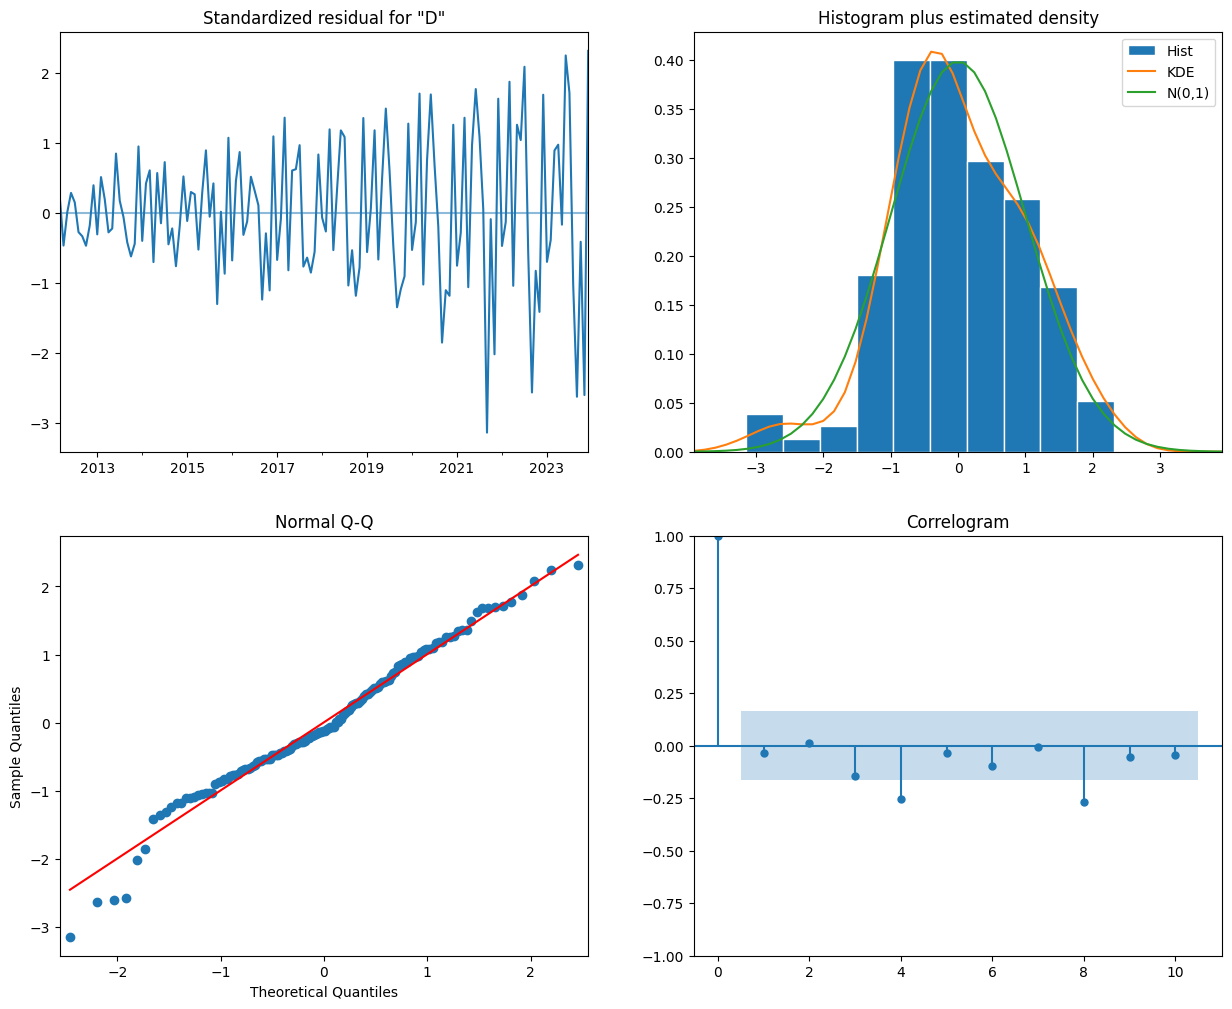

In [18]:
# Visualização dos resultados
modelo_fit.plot_diagnostics(figsize=(15,12))
plt.show()

## Forecast - Previsões dos Valores Futuros

In [19]:
# Prevendo os valores futuros
forecast = modelo_fit.get_forecast(steps=12)

In [20]:
print(forecast.summary_frame())

Demanda_Produtos        mean     mean_se  mean_ci_lower  mean_ci_upper
2024-01-01        480.996747   30.825332     420.580208     541.413287
2024-02-01        472.392236   54.343981     365.879989     578.904482
2024-03-01        479.024008   67.934235     345.875354     612.172663
2024-04-01        473.546878   79.157732     318.400574     628.693181
2024-05-01        481.292517   88.360608     308.108908     654.476126
2024-06-01        480.216793   97.302452     289.507491     670.926094
2024-07-01        485.609462  105.339877     279.147097     692.071827
2024-08-01        485.839048  113.107862     264.151713     707.526383
2024-09-01        489.956403  120.308465     254.156146     725.756661
2024-10-01        491.144740  127.291856     241.657287     740.632194
2024-11-01        494.571826  133.912364     232.108416     757.035237
2024-12-01        496.297301  140.353911     221.208691     771.385912


In [21]:
# Cria o dataframe com as previsões
df_previsoes = forecast.summary_frame()

In [22]:
df_previsoes

Demanda_Produtos,mean,mean_se,mean_ci_lower,mean_ci_upper
2024-01-01,480.996747,30.825332,420.580208,541.413287
2024-02-01,472.392236,54.343981,365.879989,578.904482
2024-03-01,479.024008,67.934235,345.875354,612.172663
2024-04-01,473.546878,79.157732,318.400574,628.693181
2024-05-01,481.292517,88.360608,308.108908,654.476126
2024-06-01,480.216793,97.302452,289.507491,670.926094
2024-07-01,485.609462,105.339877,279.147097,692.071827
2024-08-01,485.839048,113.107862,264.151713,707.526383
2024-09-01,489.956403,120.308465,254.156146,725.756661
2024-10-01,491.144740,127.291856,241.657287,740.632194


<Axes: >

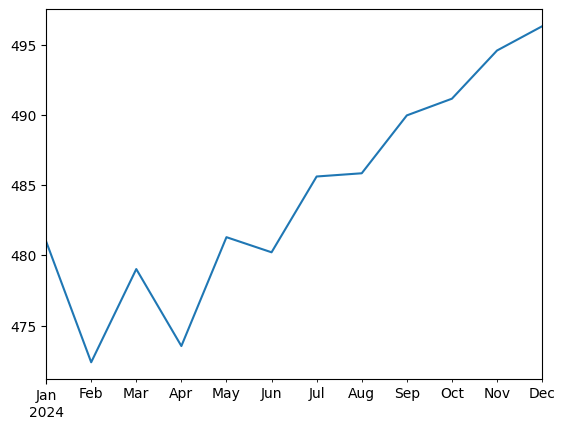

In [23]:
# Plot
df_previsoes['mean'].plot()

# Fim